In [ ]:
################################################# Download Senamhi stations for a defined time #########
import os
import pandas as pd

# Tu función process_station
def process_station(file_path, start='1981-01-01', end='2015-12-31'): # time
    date_range = pd.date_range(start=start, end=end, freq='D')
    final_df = pd.DataFrame(index=date_range)
    final_df.index.name = 'date'
    final_df['prec'] = -99.9
    final_df['tmax'] = -99.9
    final_df['tmin'] = -99.9

    with open(file_path, 'r') as f:
        years, months, days = [], [], []
        precs, tmaxs, tmins = [], [], []
        for line in f:
            parts = line.strip().split()
            years.append(int(parts[0]))
            months.append(int(parts[1]))
            days.append(int(parts[2]))
            precs.append(float(parts[3]))
            tmaxs.append(float(parts[4]))
            tmins.append(float(parts[5]))

    data = pd.DataFrame({
        'year': years,
        'month': months,
        'day': days,
        'prec': precs,
        'tmax': tmaxs,
        'tmin': tmins
    })

    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    data = data.set_index('date')
    data = data[['prec', 'tmax', 'tmin']]
    final_df.update(data)

    return final_df

# === Files ===
input_root = "D:/S/SENAMHI PERU"
output_root = "D:/S//OUTPUT_CSV_SENAMHI_corrg"  # Puedes cambiar a donde quieras guardar

# === Recorrer todos los departamentos y estaciones ===
for dept in os.listdir(input_root):
    dept_path = os.path.join(input_root, dept)
    if os.path.isdir(dept_path):
        for filename in os.listdir(dept_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(dept_path, filename)
                print(f"Procesando: {file_path}")

                # Procesar estación
                df = process_station(file_path)

                # Crear carpeta de salida si no existe
                output_dir = os.path.join(output_root, dept)
                os.makedirs(output_dir, exist_ok=True)

                # Guardar CSV con mismo nombre de estación
                output_file = os.path.join(output_dir, filename.replace('.txt', '.csv'))
                df.to_csv(output_file)

In [17]:
import os
import pandas as pd

# --- Rutas ---
base_dir = r"D:/S/SENAMHI PERU"
stations_file = os.path.join(base_dir, "Stations Senamhi.csv")
output_dir = os.path.join(base_dir, "Procesados")
os.makedirs(output_dir, exist_ok=True)

# --- Leer CSV maestro con codificación correcta ---
stations_info = pd.read_csv(stations_file, encoding="latin1")

# Crear diccionario {Station -> (Lat, Lon)}
station_coords = {row["Stations"]: (row["Lat"], row["Lon"]) 
                  for _, row in stations_info.iterrows()}

# --- Selección de departamento ---
# Si quieres todo: target_dep = None
# Si quieres solo Lima: target_dep = "Lima"
target_dep = "Lima"   # <-- cámbialo aquí según lo que quieras

# --- Recorrer carpetas de departamentos ---
for dep in os.listdir(base_dir):
    dep_path = os.path.join(base_dir, dep)
    if not os.path.isdir(dep_path) or dep == "Procesados":
        continue

    # Si se seleccionó un departamento específico y no coincide, saltar
    if target_dep is not None and dep != target_dep:
        continue

    # Carpeta de salida para el departamento
    dep_out = os.path.join(output_dir, dep)
    os.makedirs(dep_out, exist_ok=True)

    # --- Procesar cada estación (.txt) ---
    for file in os.listdir(dep_path):
        if not file.lower().endswith(".txt"):
            continue

        station_name = os.path.splitext(file)[0]
        file_path = os.path.join(dep_path, file)

        try:
            # Leer archivo txt (año, mes, día, prec, tmax, tmin)
            df = pd.read_csv(
                file_path,
                delim_whitespace=True,
                header=None,
                names=["year", "month", "day", "prec", "tmax", "tmin"]
            )

            # Crear columna de fecha
            df["Fecha"] = pd.to_datetime(df[["year", "month", "day"]], errors="coerce")

            # Extraer Fecha y Precipitación
            df_out = df[["Fecha", "prec"]].copy()
            df_out.columns = ["Fecha", "Dato"]

            # Reemplazar -99.9 por vacío
            df_out["Dato"] = df_out["Dato"].replace(-99.9, pd.NA).fillna("")

            # Convertir fecha a formato dd/mm/yyyy como TEXTO
            df_out["Fecha"] = df_out["Fecha"].dt.strftime("%d/%m/%Y")

            # Obtener coordenadas
            lat, lon = station_coords.get(station_name, ("", ""))

            # --- Construir DataFrame final con metadatos + datos ---
            final_data = [
                ["Estación", station_name],
                ["Longitud", lon],
                ["Latitud", lat],
                ["Tipo dato", "Primarios"],
                ["Operador", "SENAMHI"],
                ["Fecha", "Dato"],   # encabezado
            ]

            # Concatenar datos debajo
            combined = pd.DataFrame(final_data, columns=["Campo", "Valor"])
            data_part = df_out.rename(columns={"Fecha": "Campo", "Dato": "Valor"})
            final_df = pd.concat([combined, data_part], ignore_index=True)

            # --- Guardar en Excel ---
            out_path = os.path.join(dep_out, f"{station_name}.xlsx")
            final_df.to_excel(out_path, index=False, header=False)

            print(f"✅ Procesado: {dep}/{station_name}")

        except Exception as e:
            print(f"⚠️ Error con {dep}/{station_name}: {e}")



✅ Procesado: Lima/ALCANTARILLA
✅ Procesado: Lima/ANDAJES
✅ Procesado: Lima/ANTIOQUIA
✅ Procesado: Lima/ARAHUAY
✅ Procesado: Lima/AUTISHA
✅ Procesado: Lima/AYAVIRI
✅ Procesado: Lima/CANCHACALLA
✅ Procesado: Lima/CANTA
✅ Procesado: Lima/CARAMPOMA
✅ Procesado: Lima/CARANIA
✅ Procesado: Lima/CAÑETE
✅ Procesado: Lima/CHOSICA
✅ Procesado: Lima/DONOSO
✅ Procesado: Lima/GORGOR
✅ Procesado: Lima/HUAAEC
✅ Procesado: Lima/HUAMANTANGA
✅ Procesado: Lima/HUANCATA
✅ Procesado: Lima/HUARANGAL
✅ Procesado: Lima/HUAROS
✅ Procesado: Lima/HUAYAN
✅ Procesado: Lima/LACHAQUI
✅ Procesado: Lima/LANGA
✅ Procesado: Lima/LOMAS DE LACHAY
✅ Procesado: Lima/OYON
✅ Procesado: Lima/PACARAN
✅ Procesado: Lima/PACCHO
✅ Procesado: Lima/PACHAMACHAY
✅ Procesado: Lima/PALLAC
✅ Procesado: Lima/PAMPA LIBRE
✅ Procesado: Lima/PARIACANCHA
✅ Procesado: Lima/PARQUIN
✅ Procesado: Lima/PICOY
✅ Procesado: Lima/PIRCA
✅ Procesado: Lima/RIO BLANCO
✅ Procesado: Lima/SAN LAZARO DE ESCOMARCA
✅ Procesado: Lima/SAN PEDRO DE PILAS
✅ Procesado:

In [38]:
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
RAINday = xr.open_dataset("D:/T_JONA/TESIS_PISCO/Entrada/Pisco_Temp_day/tmin.nc")
RAINday = RAINday.rio.write_crs(4326)
RAINday

<xarray.Dataset>
Dimensions:      (X: 145, T: 13149, Y: 202)
Coordinates:
  * X            (X) float32 -81.45 -81.35 -81.25 ... -67.25 -67.15 -67.05
  * T            (T) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * Y            (Y) float32 1.35 1.25 1.15 1.05 ... -18.45 -18.55 -18.65 -18.75
    spatial_ref  int32 0
Data variables:
    tmin         (T, Y, X) float32 ...

In [4]:
des_gdf = gpd.GeoDataFrame.from_file('D:/S/Serbia1km/Interpolation/Titicaca_border/watershed.shp')
des_gdf.head()

,gid,geometry
0,0,"POLYGON ((-76.47792 -10.68208, -76.47542 -10.6..."


<AxesSubplot:>

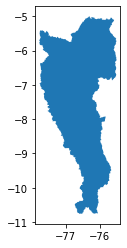

In [5]:
des_gdf.plot()

In [39]:
import pandas as pd

# quitar la hora y dejar solo la fecha
RAINday = RAINday.assign_coords(
    T=pd.to_datetime(RAINday.T.values).normalize()
)


In [41]:
deschutes_ds = RAINday['tmin'].sel(T=slice("2000-01-01", "2003-12-31")).rio.clip(des_gdf.geometry, des_gdf.crs)

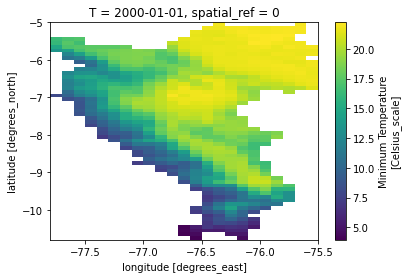

In [42]:
deschutes_ds.isel(T=0).plot()

In [43]:
deschutes_ds.rio.to_raster("D:/S/Serbia1km/Interpolation/Huallaga/tmin_2000_2003.tif")


In [ ]:
import pandas as pd

for fecha in deschutes_ds.time.values:
    fecha_str = str(pd.to_datetime(fecha).date())
    deschutes_ds.sel(time=fecha).rio.to_raster(f"precip_{fecha_str}.tif")
